In [1]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation, RandomActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from SALib.sample import sobol
from SALib.analyze.sobol import analyze
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import defaultdict
import math
import random

seed = 133

np.random.seed(seed)
random.seed(seed)

In [2]:
class Household(Agent):
    """
    Household agent that chooses whether to recycle (s=True) or not (s=False).
    Attributes:
      - P: intrinsic preference
      - C0: base cost (distance + intercept)
      - alpha: social‐influence weight
      - s: current strategy (True=Recycle, False=Not)
      - bin_id: index of assigned Bin
      - hat_rho: expected fraction of neighbors recycling
      - hat_deltaC: expected surcharge from previous bin overload
      - rho: realized fraction of neighbors recycling (after choices)
      - deltaC: surcharge carried over to next period
    """

    def __init__(self, unique_id, model, P, C0, alpha, bin_id, logit=False):
        Agent.__init__(self, unique_id, model)
        self.P = P
        self.C0 = C0
        self.alpha = alpha
        self.bin_id = bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = logit  # Use logit choice model if True


        # Initialize variables
        self.s = self.random.random() < 0.5  # initial 50‐50 choice
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0

        # Realized terms (after choices)
        self.rho = 0.0
        self.deltaC = 0.0

    def step(self):
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            # compute probabilities
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            # sample
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = True if (U_R > U_N) else False

    def advance(self):
        """
        Realize current outcomes:
          - Compute realized rho = fraction of neighbors who chose R
          - Add this agent’s choice to its bin’s Q_m (number of recyclers this period at bin m).
        """
        # 1. Realized neighbor fraction
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        if len(neigh_ids) > 0:
            neigh_choices = [self.model.households[j].s for j in neigh_ids]
            self.rho = np.mean(neigh_choices)
        else:
            self.rho = 0.0

        # 2. Contribute to bin’s Q_m if this agent recycled
        if self.s:
            bin_agent = self.model.bins[self.bin_id]
            bin_agent.Q_m += 1


class Bin(Agent):
    """
    Recycling bin agent placed on a 2D grid cell.
    Attributes:
      - K_m: capacity
      - Q_m: number of recyclers assigned this period
      - x_m, y_m: spatial coordinates
    """

    def __init__(self, unique_id, model, K_m, pos):
        Agent.__init__(self, unique_id, model)
        self.K_m = K_m
        self.Q_m = 0
        self.pos = pos

    def step(self):
        pass  # Bin has no decision to make

    def advance(self):
        pass  # Overload handled by Household.advance after Q_m increment


class RecyclingModel(Model):
    """
    Mesa Model:
    - SimultaneousActivation scheduler
    - NetworkGrid for social network
    - MultiGrid for spatial bin placement
    """

    def __init__(self, N=100, L=10, M=9, k=4, beta=0.1,
                 delta=0.5, c=0.3, kappa=0.05, epsilon=0.05,
                 alpha=0.4, K_default=10, logit=False, lambda_param=1.0, seed=seed, activation='random'):
        Model.__init__(self)
        # 1. Seed for reproducibility
        self.seed = seed if seed is not None else 0
        self.random = np.random.RandomState(self.seed)
        nx_seed = self.random.randint(1e9)

        # Store parameters
        self.num_agents = N
        self.grid_size = L
        self.num_bins = M
        self.delta = delta
        self.c = c
        self.kappa = kappa
        self.epsilon = epsilon
        self.alpha = alpha
        self.K_default = K_default
        self.logit = logit
        self.lambda_param = lambda_param

        # 2. Build social network with NetworkX and create grid and scheduler
        self.G = nx.watts_strogatz_graph(n=N, k=k, p=beta, seed=nx_seed)
        self.net = NetworkGrid(self.G)

        self.grid = MultiGrid(width=L, height=L, torus=False)
        self.schedule = RandomActivation(self) if activation == 'random' else SimultaneousActivation(self)


        # 3. Initialize agents
        self.households = {}
        self.bins = {}     

        # 3a. Place bins on a 3×3 subgrid within L×L
        bin_positions = [(x, y) for x in [2, 5, 8] for y in [2, 5, 8]]
        for m, (x_m, y_m) in enumerate(bin_positions):
            bin_id = N + m 
            bin_agent = Bin(unique_id=bin_id, model=self, K_m=K_default, pos=(x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        # 3b. Initialize household attributes
        coords = [(i, j) for i in range(L) for j in range(L)]
        coords = coords[:N]
        P_vals = np.random.rand(N)
        num_champ = int(epsilon * N)
        champions = self.random.choice(N, size=num_champ, replace=False)
        for i in champions:
            P_vals[i] = 2.0  # high preference for eco‐champions

        # Compute assigned bin and base cost C0 for each household
        for i in range(N):
            x_i, y_i = coords[i]
            # find nearest bin by Euclidean distance
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos))
                     for m in self.bins]
            bin_id = int(np.argmin(dists))
            dist_to_bin = dists[bin_id]
            C0_i = c + kappa * dist_to_bin
            if i in champions:
                C0_i = 0.0  # champion has no base cost

            # Create Household agent and add to scheduler
            house_agent = Household(unique_id=i,
                                    model=self,
                                    P=P_vals[i],
                                    C0=C0_i,
                                    alpha=1.0 if i in champions else alpha,
                                    bin_id=bin_id,
                                    logit=self.logit)
            self.households[i] = house_agent
            self.schedule.add(house_agent)

            # Place the household on the grid (not on bin cell)
            self.grid.place_agent(house_agent, coords[i])

            # Add to the social network grid at node i
            self.net.place_agent(house_agent, i)

        # 4. Initialize previous rho and deltaC
        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            if neigh_ids:
                agent.rho = np.mean([self.households[j].s for j in neigh_ids])
            else:
                agent.rho = 0.0
            agent.deltaC = 0.0  # no surcharge for first decision
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0

        # 5. DataCollector to track metrics each round
        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho":         lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins":     lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m)
            },
            agent_reporters={
                "Strategy": lambda a: a.s if isinstance(a, Household) else None,
                "Rho":      lambda a: a.rho if isinstance(a, Household) else None,
                "DeltaC":   lambda a: a.deltaC if isinstance(a, Household) else None
            }
        )


    def step(self):
        """
        One step of the model:
          (1) Each Household reads hat_rho and hat_deltaC from last period,
              computes U_exp(R/N) and sets s by best‐response (already implemented).
          (2) Each Bin resets Q_m=0.
          (3) Advance Households: compute realized rho and increment Q_m.
          (4) Advance Bins.
          (5) Compute new deltaC for next period, set hat_rho from rho.
          (6) Collect data.
        """

        # (2) Reset bin counts
        for bin_agent in self.bins.values():
            bin_agent.Q_m = 0

        # (3-4)
        self.schedule.step()

        # (5) Update surcharges and prepare for next round
        for i, agent in self.households.items():
            # Realized rho was set in agent.rho during advance()
            # Surcharge for next period:
            bin_agent = self.bins[agent.bin_id]
            overload = max(0, bin_agent.Q_m - bin_agent.K_m)
            agent.deltaC = self.delta * overload

            # Set hat_rho and hat_deltaC for next step:
            agent.hat_rho = agent.rho
            agent.hat_deltaC = agent.deltaC

        # (6) Collect data
        self.datacollector.collect(self)

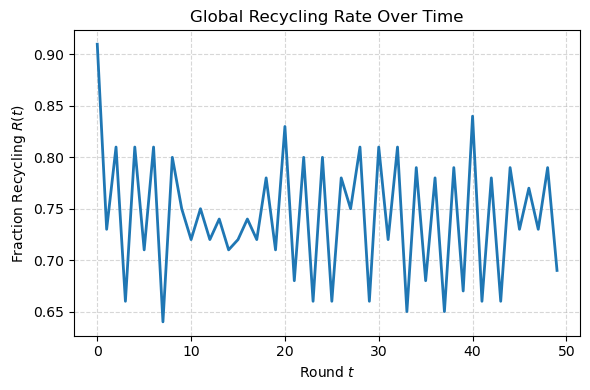

Final fraction recycling R(T) = 0.690
Average over last 10 rounds   = 0.744
Min fraction recycling       = 0.640
Max fraction recycling       = 0.910


In [3]:
# Run model

if __name__ == "__main__":
    # Instantiate the model
    model = RecyclingModel(
        N=100,       # households
        L=10,        # grid size
        M=9,         # bins
        k=4,         # average degree
        beta=0.1,    # rewiring probability
        delta=0.7,
        c=0.3,
        kappa=0.05,
        epsilon=0.05,
        alpha=0.5,
        K_default=10,
        logit=True,
        lambda_param=20,
        activation='simultaneous'
    )

    # Run for T steps
    T = 50
    for _ in range(T):
        model.step()

    # Get model data
    model_data = model.datacollector.get_model_vars_dataframe()

    # Plot Recycling Rate over time
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,4))
    plt.plot(model_data["Global_Recycle_Rate"], lw=2)
    plt.xlabel("Round $t$")
    plt.ylabel("Fraction Recycling $R(t)$")
    plt.title("Global Recycling Rate Over Time")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    final_R = model_data["Global_Recycle_Rate"].iloc[-1]
    avg_last10 = model_data["Global_Recycle_Rate"].iloc[-10:].mean()
    print(f"Final fraction recycling R(T) = {final_R:.3f}")
    print(f"Average over last 10 rounds   = {avg_last10:.3f}")
    print(f"Min fraction recycling       = {model_data['Global_Recycle_Rate'].min():.3f}")
    print(f"Max fraction recycling       = {model_data['Global_Recycle_Rate'].max():.3f}")


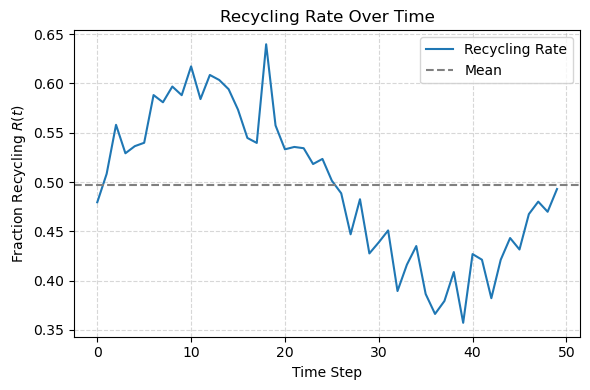

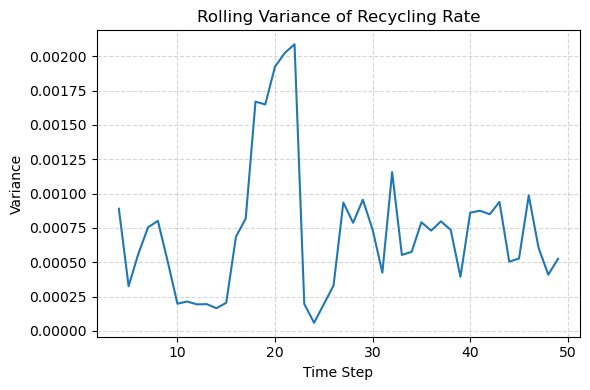

{'Mean Recycling Rate': 0.49647932259478905,
 'Std Dev': 0.07500940603086628,
 'Variance': 0.00562641099310336,
 'Avg ΔR(t)': 0.026851916384442134,
 'Max ΔR(t)': 0.10011917042833351,
 'Converges by step': 25}

In [4]:


# simulate example recycling rate data
np.random.seed(133)
T = 50
baseline = 0.5 + 0.1 * np.sin(np.linspace(0, 2 * np.pi, T))  # base signal
noise = np.random.normal(0, 0.02, T)
R_t = baseline + noise
R_t = np.clip(R_t, 0, 1)  # to ensure values in [0, 1]

# stability metrics
mean_R = np.mean(R_t)
std_R = np.std(R_t)
var_R = np.var(R_t)
delta_R = np.abs(np.diff(R_t))  
avg_change = np.mean(delta_R)
max_change = np.max(delta_R)

# time until the system convergence (within epsilon of final value)
final_value = R_t[-1]
eps = 0.01
convergence_index = next((i for i, val in enumerate(R_t) if np.abs(val - final_value) < eps), None)

# rolling window variance for stabilizxation detection
window_size = 5
rolling_var = pd.Series(R_t).rolling(window=window_size).var()

# plots for recycling rate and rolling variance
plt.figure(figsize=(6, 4))
plt.plot(R_t, label='Recycling Rate')
plt.axhline(mean_R, color='gray', linestyle='--', label='Mean')
plt.title('Recycling Rate Over Time')
plt.xlabel('Time Step')
plt.ylabel('Fraction Recycling $R(t)$')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(rolling_var, label=f'{window_size}-Step Rolling Variance')
plt.title('Rolling Variance of Recycling Rate')
plt.xlabel('Time Step')
plt.ylabel('Variance')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# display summary statistics as well
summary = {
    "Mean Recycling Rate": mean_R,
    "Std Dev": std_R,
    "Variance": var_R,
    "Avg ΔR(t)": avg_change,
    "Max ΔR(t)": max_change,
    "Converges by step": convergence_index if convergence_index is not None else "Not within ε=0.01",
}
summary


In [5]:



# here we define the sensitivity analysis problem
problem = {
    'num_vars': 7,
    'names': ['alpha', 'delta', 'lambda_param', 'c', 'kappa', 'K_default', 'beta'],
    'bounds': [
        [0.1, 1.0],     # alpha
        [0.1, 1.0],     # delta
        [1.0, 30.0],    # lambda_param
        [0.0, 1.0],     # c
        [0.01, 0.1],    # kappa
        [5, 20],        # K_default
        [0.0, 0.3]      # beta
    ]
}

# generate Sobol samples
param_values = sobol.sample(problem, 512, calc_second_order=False)

# define the actual model stability function
def stability_metric(params, seed):
    alpha, delta, lam, c, kappa, K, beta = params
    print(f"Running model #{seed} | alpha={alpha:.2f}, delta={delta:.2f}, lambda={lam:.2f}, c={c:.2f}, "
          f"kappa={kappa:.3f}, K={int(K)}, beta={beta:.3f}")
    try:
        model = RecyclingModel(
            alpha=alpha,
            delta=delta,
            lambda_param=lam,
            c=c,
            kappa=kappa,
            K_default=int(K),
            beta=beta,
            logit=True,
            seed=seed
        )
        for _ in range(50):
            model.step()
        R = model.datacollector.get_model_vars_dataframe()["Global_Recycle_Rate"]
        return np.var(R[-10:])  # use the variance of last 10 steps as a proxy for stability
    except Exception as e:
        print(f"Failed: seed={seed} params={params}. Error: {e}")
        return np.nan

# setup for parallel running to imporve time efficiency
Y = Parallel(n_jobs=-1)(delayed(stability_metric)(p, seed=133 + i) for i, p in enumerate(param_values))
Y = np.asarray(Y)

# remove the failed runs before analysis
valid_mask = ~np.isnan(Y)
Y_valid = Y[valid_mask]
params_valid = np.array(param_values)[valid_mask]

# run the analysis on valid results
Si = analyze(problem, Y_valid, calc_second_order=False, print_to_console=False)

# return in dictionary format
Si_result = {
    "First-order (S1)": dict(zip(problem['names'], Si['S1'])),
    "Total-order (ST)": dict(zip(problem['names'], Si['ST']))
}
Si_result


c:\Users\elias\anaconda3\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


{'First-order (S1)': {'alpha': 0.02481211644095655,
  'delta': -0.026569256440354152,
  'lambda_param': 0.5701494316588344,
  'c': 0.08271879946611604,
  'kappa': -0.016222767895177428,
  'K_default': -0.009851300001603698,
  'beta': -0.011939803999534126},
 'Total-order (ST)': {'alpha': 0.3735633325465703,
  'delta': 0.32224594942555146,
  'lambda_param': 0.8938856210321074,
  'c': 0.4039613878952396,
  'kappa': 0.2597696468833094,
  'K_default': 0.25591112269975264,
  'beta': 0.3188379829830248}}

In [6]:


# expanded parameter space with the addition of epsilon, k, and M
problem = {
    'num_vars': 10,
    'names': ['alpha', 'delta', 'lambda_param', 'c', 'kappa', 'K_default', 'beta', 'epsilon', 'k', 'M'],
    'bounds': [
        [0.1, 1.0],      # alpha
        [0.1, 1.0],      # delta
        [1.0, 30.0],     # lambda_param
        [0.0, 1.0],      # c
        [0.01, 0.1],     # kappa
        [5, 20],         # K_default
        [0.0, 0.3],      # beta
        [0.0, 0.2],      # epsilon (fraction of eco-champions)
        [2, 10],         # k (average degree in Watts-Strogatz)
        [4, 16]          # M (number of bins)
    ]
}



# generate Sobol samples
param_values = sobol.sample(problem, 1024, calc_second_order=False)  # feel free to adjust N

# define the model evaluation function
def stability_metric(params, seed):
    alpha, delta, lam, c, kappa, K, beta, epsilon, k, M = params
    print(f"Running model | seed={seed} | alpha={alpha:.2f}, delta={delta:.2f}, lambda={lam:.2f}, "
          f"c={c:.2f}, kappa={kappa:.3f}, K={int(K)}, beta={beta:.3f}, epsilon={epsilon:.3f}, "
          f"k={int(k)}, M={int(M)}")
    try:
        model = RecyclingModel(
            alpha=alpha,
            delta=delta,
            lambda_param=lam,
            c=c,
            kappa=kappa,
            K_default=int(K),
            beta=beta,
            epsilon=epsilon,
            k=int(k),
            M=int(M),
            logit=True,
            seed=seed
        )
        for _ in range(50):
            model.step()
        R = model.datacollector.get_model_vars_dataframe()["Global_Recycle_Rate"]
        return np.var(R[-10:])
    except Exception as e:
        print(f"Error at seed={seed}, params={params}: {e}")
        return np.nan


# run in parallel
Y = Parallel(n_jobs=-1)(
    delayed(stability_metric)(p, seed=133 + i)
    for i, p in enumerate(tqdm(param_values, desc="Sobol Evaluation Progress"))
)
Y = np.asarray(Y)

# filter out the failed simulations
valid_mask = ~np.isnan(Y)
Y_valid = Y[valid_mask]
params_valid = np.array(param_values)[valid_mask]


# sobol sensitivity analysis
Si = analyze(problem, Y_valid, calc_second_order=False, print_to_console=False)

# results
Si_result = {
    "First-order (S1)": dict(zip(problem['names'], Si['S1'])),
    "Total-order (ST)": dict(zip(problem['names'], Si['ST']))
}
Si_result


Sobol Evaluation Progress: 100%|██████████| 12288/12288 [01:09<00:00, 176.99it/s]


{'First-order (S1)': {'alpha': 0.041927632011179966,
  'delta': 0.006186812612871847,
  'lambda_param': 0.5371364960649656,
  'c': 0.050070987540913194,
  'kappa': -0.027398056333414914,
  'K_default': -0.003420530189166833,
  'beta': 0.013376817779207139,
  'epsilon': 0.011360630861545866,
  'k': 0.00796552674667607,
  'M': -0.0011827533234522554},
 'Total-order (ST)': {'alpha': 0.3595302742521183,
  'delta': 0.2536466911414025,
  'lambda_param': 0.8103929938718705,
  'c': 0.35936936504939504,
  'kappa': 0.2547924928476625,
  'K_default': 0.23306799789120863,
  'beta': 0.24895345312508846,
  'epsilon': 0.2319812340380027,
  'k': 0.2597742935664989,
  'M': 0.2587168264939935}}

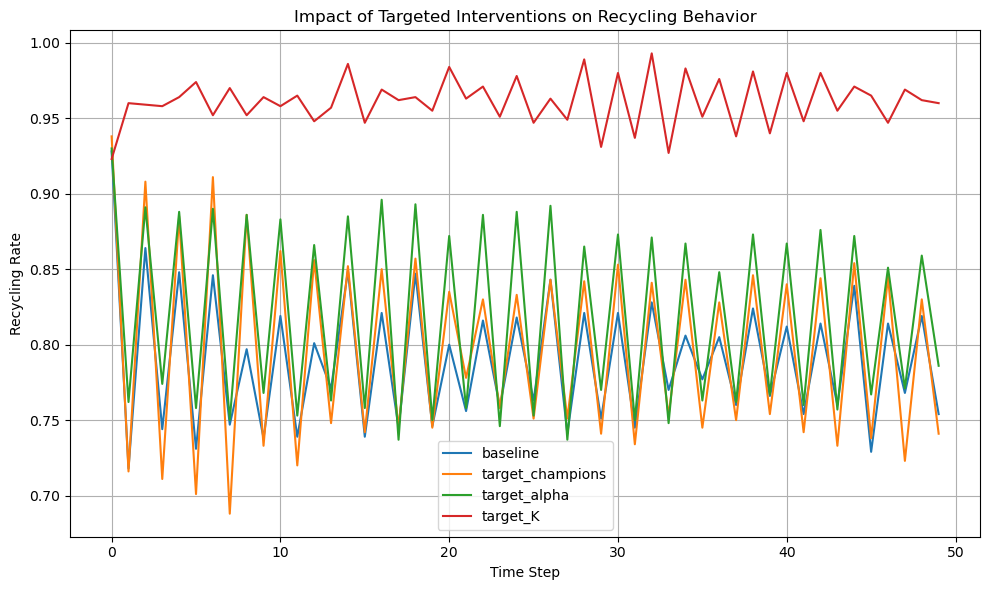

In [7]:
# simulation code to explore targeted interventions in heterogeneous environments



# define the simulation function that will compare the targeted interventions
def simulate_interventions(num_runs=10, T=50):
    interventions = {
        "baseline": {},
        "target_champions": {"epsilon": 0.1},  # increase eco-champions
        "target_alpha": {"targeted_alpha": True},  # give high alpha to high-degree nodes
        "target_K": {"targeted_K": True}  # place more bins in high-density areas
    }

    results = defaultdict(list)

    for label, params in interventions.items():
        for run in range(num_runs):
            # custom init
            model = RecyclingModel(
                N=100, L=10, M=9, k=4, beta=0.1,
                delta=0.5, c=0.3, kappa=0.05,
                epsilon=params.get("epsilon", 0.05),
                alpha=0.4, K_default=10,
                logit=True, lambda_param=15,
                activation='simultaneous', seed=run
            )

            # apply targeted alpha intervention
            if params.get("targeted_alpha", False):
                degrees = dict(model.G.degree())
                sorted_nodes = sorted(degrees.items(), key=lambda x: -x[1])
                top_nodes = [i for i, _ in sorted_nodes[:int(0.2 * model.num_agents)]]
                for i in top_nodes:
                    model.households[i].alpha = 1.0  # strong social influence

            # apply targeted K intervention (bin capacity)
            if params.get("targeted_K", False):
                for m, bin_agent in model.bins.items():
                    x, y = bin_agent.pos
                    density = sum(1 for a in model.grid.get_cell_list_contents([(x+dx, y+dy)
                              for dx in [-1, 0, 1] for dy in [-1, 0, 1]
                              if model.grid.out_of_bounds((x+dx, y+dy)) is False]
                    ) if isinstance(a, Household))
                    bin_agent.K_m = 10 + int(density / 2)

            # run the model
            for _ in range(T):
                model.step()

            df = model.datacollector.get_model_vars_dataframe()
            results[label].append(df["Global_Recycle_Rate"].values)

    return results

# run the experiments
intervention_results = simulate_interventions(num_runs=10, T=50)

# plots
plt.figure(figsize=(10, 6))
for label, runs in intervention_results.items():
    avg_curve = np.mean(runs, axis=0)
    plt.plot(avg_curve, label=label)
plt.xlabel("Time Step")
plt.ylabel("Recycling Rate")
plt.title("Impact of Targeted Interventions on Recycling Behavior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
